In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import train_test_split

import torchvision.models as models
from tqdm import tqdm
import time
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import json


In [3]:

DATASET_PATH = "/kaggle/input/utkface-dataset-face-aligned-and-labeled/utkface-aligned-labeled"
CSV_FILE     = os.path.join(DATASET_PATH, "labels.csv")
IMAGES_DIR   = os.path.join(DATASET_PATH, "images")

# Charger le CSV
df = pd.read_csv(CSV_FILE)
print(f"Total images dans CSV: {len(df)}")


Total images dans CSV: 23705


In [4]:

df['age_group'] = pd.cut(
    df['age'],
    bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 120],
    labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81+']
)

df['stratify_key'] = (
    df['age_group'].astype(str) + '_' +
    df['gender'].astype(str) + '_' +
    df['race'].astype(str)
)

# Gérer les groupes rares (<5 images)
stratify_counts = df['stratify_key'].value_counts()
rare_groups = stratify_counts[stratify_counts < 5].index
df.loc[df['stratify_key'].isin(rare_groups), 'stratify_key'] = 'rare_group'

print(f"Nombre de groupes uniques: {df['stratify_key'].nunique()}")



Nombre de groupes uniques: 87


In [5]:

class_weights_race = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['race']),
    y=df['race'].values
)
race_weight_dict = {i: w for i, w in enumerate(class_weights_race)}
race_names = ['White', 'Black', 'Asian', 'Indian', 'Others']
for i, w in race_weight_dict.items():
    count = (df['race'] == i).sum()
    print(f"{race_names[i]}: {w:.2f} (n={count})")



White: 0.47 (n=10078)
Black: 1.05 (n=4526)
Asian: 1.38 (n=3434)
Indian: 1.19 (n=3975)
Others: 2.80 (n=1692)


In [6]:

images = df['image'].values
ages   = df['age'].values
genders = df['gender'].values
races  = df['race'].values

# Premier split
X_train, X_temp, age_train, age_temp, gender_train, gender_temp, race_train, race_temp, key_train, key_temp = train_test_split(
    images, ages, genders, races, df['stratify_key'].values,
    test_size=0.3, stratify=df['stratify_key'], random_state=42
)

# Fix stratify rare pour second split
temp_counts = pd.Series(key_temp).value_counts()
rare_temp = temp_counts[temp_counts < 2].index
key_temp_fixed = key_temp.copy()
key_temp_fixed[np.isin(key_temp, rare_temp)] = 'rare_group'

# Second split
X_val, X_test, age_val, age_test, gender_val, gender_test, race_val, race_test, key_val, key_test = train_test_split(
    X_temp, age_temp, gender_temp, race_temp,
    key_temp_fixed, test_size=0.5, stratify=key_temp_fixed, random_state=42
)

print("Split terminé:")
print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))


Split terminé:
Train: 16593 Val: 3556 Test: 3556


In [7]:

def filter_existing(images, ages, genders, races):
    existing_idx = []
    for i, img_name in enumerate(images):
        img_path = os.path.join(IMAGES_DIR, img_name)
        if os.path.isfile(img_path):
            existing_idx.append(i)
    if len(existing_idx) == 0:
        raise ValueError("Aucune image valide trouvée !")
    return images[existing_idx], ages[existing_idx], genders[existing_idx], races[existing_idx]

X_train, age_train, gender_train, race_train = filter_existing(X_train, age_train, gender_train, race_train)
X_val, age_val, gender_val, race_val       = filter_existing(X_val, age_val, gender_val, race_val)
X_test, age_test, gender_test, race_test   = filter_existing(X_test, age_test, gender_test, race_test)

print("Après filtrage des fichiers manquants:")
print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))


Après filtrage des fichiers manquants:
Train: 16593 Val: 3556 Test: 3556


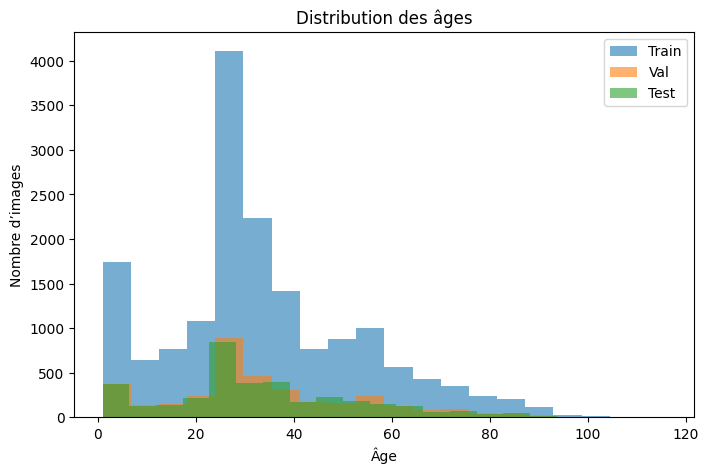

In [8]:
def plot_age_distribution():
    plt.figure(figsize=(8,5))
    plt.hist(age_train, bins=20, alpha=0.6, label='Train')
    plt.hist(age_val, bins=20, alpha=0.6, label='Val')
    plt.hist(age_test, bins=20, alpha=0.6, label='Test')
    plt.xlabel("Âge")
    plt.ylabel("Nombre d’images")
    plt.title("Distribution des âges")
    plt.legend()
    plt.show()

plot_age_distribution()


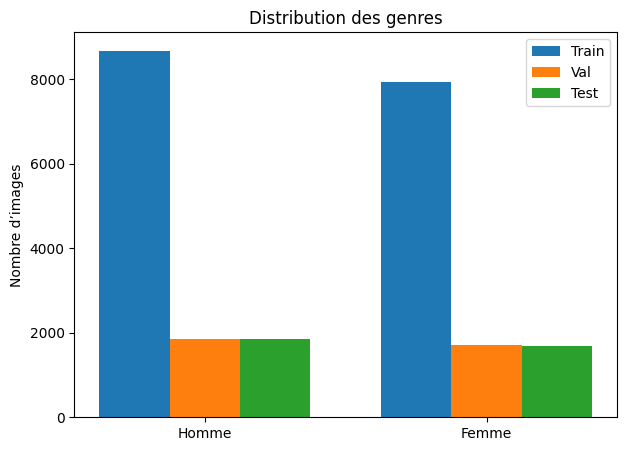

In [9]:
def plot_gender_distribution():
    labels = ['Homme', 'Femme']

    train_counts = [(gender_train == 0).sum(), (gender_train == 1).sum()]
    val_counts   = [(gender_val == 0).sum(),   (gender_val == 1).sum()]
    test_counts  = [(gender_test == 0).sum(),  (gender_test == 1).sum()]

    x = np.arange(len(labels))
    width = 0.25

    plt.figure(figsize=(7,5))
    plt.bar(x - width, train_counts, width, label='Train')
    plt.bar(x, val_counts, width, label='Val')
    plt.bar(x + width, test_counts, width, label='Test')

    plt.xticks(x, labels)
    plt.ylabel("Nombre d’images")
    plt.title("Distribution des genres")
    plt.legend()
    plt.show()

plot_gender_distribution()


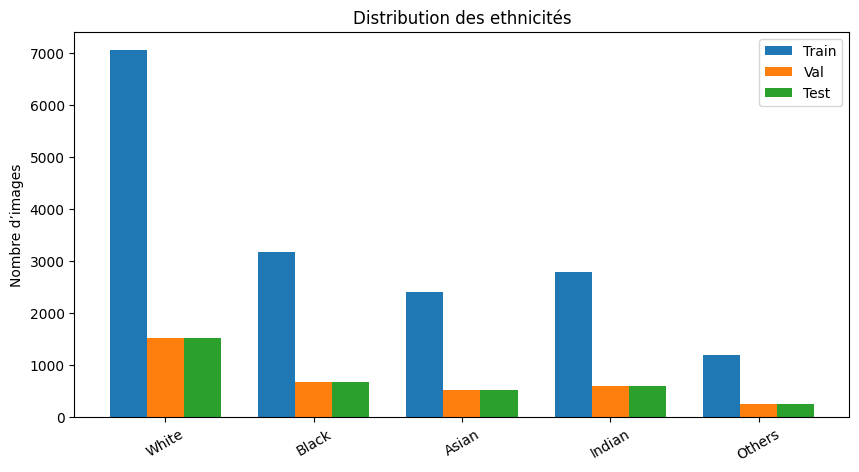

In [10]:
def plot_race_distribution():
    race_names = ['White', 'Black', 'Asian', 'Indian', 'Others']

    train_counts = [(race_train == i).sum() for i in range(5)]
    val_counts   = [(race_val == i).sum() for i in range(5)]
    test_counts  = [(race_test == i).sum() for i in range(5)]

    x = np.arange(len(race_names))
    width = 0.25

    plt.figure(figsize=(10,5))
    plt.bar(x - width, train_counts, width, label='Train')
    plt.bar(x, val_counts, width, label='Val')
    plt.bar(x + width, test_counts, width, label='Test')

    plt.xticks(x, race_names, rotation=30)
    plt.ylabel("Nombre d’images")
    plt.title("Distribution des ethnicités")
    plt.legend()
    plt.show()

plot_race_distribution()


In [11]:


train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])



In [12]:
# ==========================
#  Dataset et DataLoaders
# ==========================
class UTKFaceDataset(Dataset):
    def __init__(self, images_list, ages, genders, races, transform=None):
        self.images_list = images_list
        self.ages = ages
        self.genders = genders
        self.races = races
        self.transform = transform
    def __len__(self):
        return len(self.images_list)
    def __getitem__(self, idx):
        img_path = os.path.join(IMAGES_DIR, self.images_list[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        age = torch.tensor(self.ages[idx], dtype=torch.float32)
        gender = torch.tensor(self.genders[idx], dtype=torch.float32)
        race = torch.tensor(self.races[idx], dtype=torch.long)
        return image, age, gender, race

train_dataset = UTKFaceDataset(X_train, age_train, gender_train, race_train, transform=train_transform)
val_dataset   = UTKFaceDataset(X_val, age_val, gender_val, race_val, transform=val_test_transform)
test_dataset  = UTKFaceDataset(X_test, age_test, gender_test, race_test, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("DataLoaders prêts !")


DataLoaders prêts !


In [13]:

class MultiTaskResNet50(nn.Module):
    def __init__(self, num_races=5):
        super(MultiTaskResNet50, self).__init__()

        # Backbone ResNet50 pré-entraîné
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        in_features = 2048

        # ========================================
        # TÊTE ÂGE (Régression) - 3 couches FC
        # ========================================
        self.age_head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(128, 1)  # Sortie continue
        )

        # ========================================
        # TÊTE GENRE (Binaire) - 3 couches FC
        # ========================================
        self.gender_head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(64, 1)  # Sortie + Sigmoid dans la loss
        )

        # ========================================
        # TÊTE ETHNIE (5 classes) - 3 couches FC
        # ========================================
        self.race_head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(128, num_races)  # Softmax dans la loss
        )

    def forward(self, x):
        # Extraction des features
        features = self.backbone(x)
        features = features.view(features.size(0), -1)  # [B, 2048]

        # Prédictions
        age_out = self.age_head(features).squeeze()      # [B]
        gender_out = self.gender_head(features).squeeze()  # [B]
        race_out = self.race_head(features)              # [B, 5]

        return age_out, gender_out, race_out



In [14]:
# ==========================
# CONFIGURATION
# ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device utilisé : {device}")

# Créer le modèle
model = MultiTaskResNet50(num_races=5).to(device)

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✓ Paramètres totaux : {total_params:,}")
print(f"✓ Paramètres entraînables : {trainable_params:,}")

# ==========================
# FONCTIONS DE PERTE
# ==========================
# ✅ MAE pour l'âge (L1Loss)
criterion_age = nn.L1Loss()

# ✅ BCE pour le genre (binaire)
criterion_gender = nn.BCEWithLogitsLoss()

# ✅ CrossEntropy pour l'ethnie avec poids de classe
race_weights_tensor = torch.tensor(
    list(race_weight_dict.values()),
    dtype=torch.float32
).to(device)
criterion_race = nn.CrossEntropyLoss(weight=race_weights_tensor)

print("\n✓ Loss functions configurées :")
print(f"  - Âge : MAE (L1Loss)")
print(f"  - Genre : BCE")
print(f"  - Ethnie : CrossEntropy avec poids {race_weights_tensor.cpu().numpy()}")



🖥️  Device utilisé : cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


✓ Paramètres totaux : 25,722,055
✓ Paramètres entraînables : 25,722,055

✓ Loss functions configurées :
  - Âge : MAE (L1Loss)
  - Genre : BCE
  - Ethnie : CrossEntropy avec poids [0.47043064 1.0475034  1.3806057  1.1927044  2.8020093 ]


In [15]:
# ==========================
# OPTIMISEUR ET SCHEDULER
# ==========================
optimizer = optim.Adam(
    model.parameters(),
    lr=0.0001,           # Learning rate initial
    weight_decay=0.0001  # Régularisation L2
)

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,  # Réduire LR tous les 10 epochs
    gamma=0.5      # Facteur de réduction
)

print("✓ Optimiseur : Adam (lr=0.0001, weight_decay=0.0001)")
print("✓ Scheduler : StepLR (step=10, gamma=0.5)")


✓ Optimiseur : Adam (lr=0.0001, weight_decay=0.0001)
✓ Scheduler : StepLR (step=10, gamma=0.5)


In [16]:


NUM_EPOCHS = 50

PATIENCE = 25  # Early stopping

# ==========================
# ENTRAÎNEMENT
# ==========================
print("\n" + "="*70)
print(f"DÉBUT DE L'ENTRAÎNEMENT ({NUM_EPOCHS} epochs max)")
print("="*70)

best_val_mae = float('inf')
patience_counter = 0
history = {'train': [], 'val': []}

for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start = time.time()

    # ========================================
    # PHASE TRAIN
    # ========================================
    model.train()
    train_loss = 0.0
    train_loss_age = 0.0
    train_loss_gender = 0.0
    train_loss_race = 0.0
    train_mae = 0.0
    train_gender_correct = 0
    train_race_correct = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch:03d} [TRAIN]")
    for images, ages, genders, races in pbar:
        images = images.to(device)
        ages = ages.to(device)
        genders = genders.to(device)
        races = races.to(device)

        # Forward pass
        optimizer.zero_grad()
        age_out, gender_out, race_out = model(images)

        # Calcul des pertes individuelles
        loss_age = criterion_age(age_out, ages)
        loss_gender = criterion_gender(gender_out, genders)
        loss_race = criterion_race(race_out, races)

        # Perte totale (λ_age=1.0, λ_gender=0.5, λ_race=0.5)
        loss = 1.0 * loss_age + 0.5 * loss_gender + 0.5 * loss_race

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumuler les métriques
        batch_size = images.size(0)
        train_loss += loss.item() * batch_size
        train_loss_age += loss_age.item() * batch_size
        train_loss_gender += loss_gender.item() * batch_size
        train_loss_race += loss_race.item() * batch_size
        train_mae += torch.sum(torch.abs(age_out - ages)).item()
        train_gender_correct += torch.sum((torch.sigmoid(gender_out) > 0.5) == genders).item()
        train_race_correct += torch.sum(torch.argmax(race_out, 1) == races).item()

        # Mettre à jour la barre de progression
        pbar.set_postfix({
            'Loss': f"{loss.item():.4f}",
            'MAE': f"{loss_age.item():.2f}"
        })

    # Moyennes train
    train_loss /= len(train_loader.dataset)
    train_loss_age /= len(train_loader.dataset)
    train_loss_gender /= len(train_loader.dataset)
    train_loss_race /= len(train_loader.dataset)
    train_mae /= len(train_loader.dataset)
    train_gender_acc = train_gender_correct / len(train_loader.dataset)
    train_race_acc = train_race_correct / len(train_loader.dataset)

    # ========================================
    # PHASE VALIDATION
    # ========================================
    model.eval()
    val_loss = 0.0
    val_loss_age = 0.0
    val_loss_gender = 0.0
    val_loss_race = 0.0
    val_mae = 0.0
    val_gender_correct = 0
    val_race_correct = 0

    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"Epoch {epoch:03d} [VAL]  ")
        for images, ages, genders, races in pbar:
            images = images.to(device)
            ages = ages.to(device)
            genders = genders.to(device)
            races = races.to(device)

            # Forward pass
            age_out, gender_out, race_out = model(images)

            # Calcul des pertes
            loss_age = criterion_age(age_out, ages)
            loss_gender = criterion_gender(gender_out, genders)
            loss_race = criterion_race(race_out, races)
            loss = 1.0 * loss_age + 0.5 * loss_gender + 0.5 * loss_race

            # Accumuler les métriques
            batch_size = images.size(0)
            val_loss += loss.item() * batch_size
            val_loss_age += loss_age.item() * batch_size
            val_loss_gender += loss_gender.item() * batch_size
            val_loss_race += loss_race.item() * batch_size
            val_mae += torch.sum(torch.abs(age_out - ages)).item()
            val_gender_correct += torch.sum((torch.sigmoid(gender_out) > 0.5) == genders).item()
            val_race_correct += torch.sum(torch.argmax(race_out, 1) == races).item()

            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'MAE': f"{loss_age.item():.2f}"
            })

    # Moyennes validation
    val_loss /= len(val_loader.dataset)
    val_loss_age /= len(val_loader.dataset)
    val_loss_gender /= len(val_loader.dataset)
    val_loss_race /= len(val_loader.dataset)
    val_mae /= len(val_loader.dataset)
    val_gender_acc = val_gender_correct / len(val_loader.dataset)
    val_race_acc = val_race_correct / len(val_loader.dataset)

    # Temps d'epoch
    epoch_time = time.time() - epoch_start
    current_lr = optimizer.param_groups[0]['lr']

    # ========================================
    # AFFICHAGE DES RÉSULTATS
    # ========================================
    print(f"\nEpoch {epoch:03d} terminée ({epoch_time/60:.1f} min, LR={current_lr:.6f})")
    print(f"  TRAIN → Loss: {train_loss:.4f} | MAE: {train_mae:.2f} | "
          f"Gender: {train_gender_acc*100:.1f}% | Race: {train_race_acc*100:.1f}%")
    print(f"  VAL   → Loss: {val_loss:.4f} | MAE: {val_mae:.2f} | "
          f"Gender: {val_gender_acc*100:.1f}% | Race: {val_race_acc*100:.1f}%")

    # Sauvegarder l'historique
    history['train'].append({
        'loss': train_loss,
        'mae': train_mae,
        'gender_acc': train_gender_acc,
        'race_acc': train_race_acc
    })
    history['val'].append({
        'loss': val_loss,
        'mae': val_mae,
        'gender_acc': val_gender_acc,
        'race_acc': val_race_acc
    })

    # ========================================
    # EARLY STOPPING
    # ========================================
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        patience_counter = 0

        # Sauvegarder le meilleur modèle
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_mae': best_val_mae,
            'val_gender_acc': val_gender_acc,
            'val_race_acc': val_race_acc
        }, "best_model.pth")

        print(f"  ✓ Nouveau meilleur modèle sauvegardé (MAE: {best_val_mae:.2f})")
    else:
        patience_counter += 1
        print(f"  ⏳ Patience: {patience_counter}/{PATIENCE}")

        if patience_counter >= PATIENCE:
            print(f"\n⚠️  Early stopping déclenché après {epoch} epochs")
            break

    # Mettre à jour le scheduler
    scheduler.step()
    print("-" * 70)

# ========================================
# FIN DE L'ENTRAÎNEMENT
# ========================================
print("\n" + "="*70)
print(f"ENTRAÎNEMENT TERMINÉ !")
print("="*70)
print(f"✓ Meilleure validation MAE : {best_val_mae:.2f} ans")
print(f"✓ Modèle sauvegardé : best_model.pth")
print("="*70)

# Sauvegarder l'historique
import json
with open('training_history.json', 'w') as f:
    json.dump(history, f, indent=2)
print("✓ Historique sauvegardé : training_history.json")


DÉBUT DE L'ENTRAÎNEMENT (50 epochs max)


Epoch 001 [VAL]  : 100%|██████████| 112/112 [00:27<00:00,  4.08it/s, Loss=13.2345, MAE=12.86]



Epoch 001 terminée (5.2 min, LR=0.000100)
  TRAIN → Loss: 11.5679 | MAE: 10.51 | Gender: 66.3% | Race: 36.4%
  VAL   → Loss: 8.0647 | MAE: 7.14 | Gender: 75.8% | Race: 49.1%
  ✓ Nouveau meilleur modèle sauvegardé (MAE: 7.14)
----------------------------------------------------------------------


Epoch 002 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.34it/s, Loss=1.6157, MAE=1.44]



Epoch 002 terminée (4.8 min, LR=0.000100)
  TRAIN → Loss: 7.9970 | MAE: 7.15 | Gender: 79.1% | Race: 52.6%
  VAL   → Loss: 6.6519 | MAE: 5.96 | Gender: 83.4% | Race: 63.2%
  ✓ Nouveau meilleur modèle sauvegardé (MAE: 5.96)
----------------------------------------------------------------------


Epoch 003 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.42it/s, Loss=3.2762, MAE=3.20]



Epoch 003 terminée (4.8 min, LR=0.000100)
  TRAIN → Loss: 7.2145 | MAE: 6.52 | Gender: 84.9% | Race: 61.6%
  VAL   → Loss: 6.1987 | MAE: 5.58 | Gender: 86.7% | Race: 65.3%
  ✓ Nouveau meilleur modèle sauvegardé (MAE: 5.58)
----------------------------------------------------------------------


Epoch 004 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.49it/s, Loss=4.6815, MAE=4.64]



Epoch 004 terminée (4.8 min, LR=0.000100)
  TRAIN → Loss: 6.7262 | MAE: 6.11 | Gender: 87.4% | Race: 66.9%
  VAL   → Loss: 6.2088 | MAE: 5.67 | Gender: 88.6% | Race: 73.5%
  ⏳ Patience: 1/25
----------------------------------------------------------------------


Epoch 005 [VAL]  : 100%|██████████| 112/112 [00:19<00:00,  5.63it/s, Loss=6.1883, MAE=6.15]



Epoch 005 terminée (4.8 min, LR=0.000100)
  TRAIN → Loss: 6.3676 | MAE: 5.81 | Gender: 88.7% | Race: 70.9%
  VAL   → Loss: 6.0553 | MAE: 5.55 | Gender: 90.1% | Race: 73.8%
  ✓ Nouveau meilleur modèle sauvegardé (MAE: 5.55)
----------------------------------------------------------------------


Epoch 006 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.51it/s, Loss=3.1029, MAE=3.07]



Epoch 006 terminée (4.7 min, LR=0.000100)
  TRAIN → Loss: 6.0441 | MAE: 5.53 | Gender: 89.4% | Race: 73.6%
  VAL   → Loss: 5.8220 | MAE: 5.34 | Gender: 90.2% | Race: 76.1%
  ✓ Nouveau meilleur modèle sauvegardé (MAE: 5.34)
----------------------------------------------------------------------


Epoch 007 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.36it/s, Loss=2.3850, MAE=2.36]



Epoch 007 terminée (4.8 min, LR=0.000100)
  TRAIN → Loss: 6.0222 | MAE: 5.54 | Gender: 90.3% | Race: 75.0%
  VAL   → Loss: 5.8085 | MAE: 5.35 | Gender: 90.3% | Race: 77.9%
  ⏳ Patience: 1/25
----------------------------------------------------------------------


Epoch 008 [VAL]  : 100%|██████████| 112/112 [00:21<00:00,  5.21it/s, Loss=2.7878, MAE=2.76]



Epoch 008 terminée (4.8 min, LR=0.000100)
  TRAIN → Loss: 5.7189 | MAE: 5.26 | Gender: 90.9% | Race: 76.0%
  VAL   → Loss: 5.6337 | MAE: 5.19 | Gender: 91.1% | Race: 77.4%
  ✓ Nouveau meilleur modèle sauvegardé (MAE: 5.19)
----------------------------------------------------------------------


Epoch 009 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.41it/s, Loss=2.9483, MAE=2.93]



Epoch 009 terminée (4.8 min, LR=0.000100)
  TRAIN → Loss: 5.5709 | MAE: 5.14 | Gender: 91.2% | Race: 77.9%
  VAL   → Loss: 5.6547 | MAE: 5.20 | Gender: 91.0% | Race: 76.4%
  ⏳ Patience: 1/25
----------------------------------------------------------------------


Epoch 010 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.36it/s, Loss=1.6961, MAE=1.68]



Epoch 010 terminée (4.7 min, LR=0.000100)
  TRAIN → Loss: 5.3833 | MAE: 4.96 | Gender: 91.5% | Race: 78.0%
  VAL   → Loss: 5.4655 | MAE: 5.03 | Gender: 91.4% | Race: 78.9%
  ✓ Nouveau meilleur modèle sauvegardé (MAE: 5.03)
----------------------------------------------------------------------


Epoch 011 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.48it/s, Loss=1.9112, MAE=1.90]



Epoch 011 terminée (4.8 min, LR=0.000050)
  TRAIN → Loss: 5.0082 | MAE: 4.62 | Gender: 92.8% | Race: 80.2%
  VAL   → Loss: 5.3293 | MAE: 4.92 | Gender: 92.0% | Race: 79.5%
  ✓ Nouveau meilleur modèle sauvegardé (MAE: 4.92)
----------------------------------------------------------------------


Epoch 012 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.51it/s, Loss=2.3238, MAE=2.31]



Epoch 012 terminée (4.8 min, LR=0.000050)
  TRAIN → Loss: 4.8335 | MAE: 4.46 | Gender: 93.0% | Race: 81.1%
  VAL   → Loss: 5.2446 | MAE: 4.83 | Gender: 91.8% | Race: 77.8%
  ✓ Nouveau meilleur modèle sauvegardé (MAE: 4.83)
----------------------------------------------------------------------


Epoch 013 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.45it/s, Loss=1.7811, MAE=1.75]



Epoch 013 terminée (4.8 min, LR=0.000050)
  TRAIN → Loss: 4.7283 | MAE: 4.37 | Gender: 93.5% | Race: 81.6%
  VAL   → Loss: 5.3002 | MAE: 4.89 | Gender: 92.4% | Race: 78.8%
  ⏳ Patience: 1/25
----------------------------------------------------------------------


Epoch 014 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.58it/s, Loss=3.4061, MAE=3.39]



Epoch 014 terminée (4.7 min, LR=0.000050)
  TRAIN → Loss: 4.5490 | MAE: 4.20 | Gender: 93.7% | Race: 81.8%
  VAL   → Loss: 5.3879 | MAE: 4.97 | Gender: 91.7% | Race: 79.2%
  ⏳ Patience: 2/25
----------------------------------------------------------------------


Epoch 015 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.40it/s, Loss=1.7008, MAE=1.67]



Epoch 015 terminée (4.7 min, LR=0.000050)
  TRAIN → Loss: 4.4909 | MAE: 4.15 | Gender: 93.8% | Race: 82.1%
  VAL   → Loss: 5.2294 | MAE: 4.83 | Gender: 92.2% | Race: 79.5%
  ✓ Nouveau meilleur modèle sauvegardé (MAE: 4.83)
----------------------------------------------------------------------


Epoch 016 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.40it/s, Loss=2.1367, MAE=2.11]



Epoch 016 terminée (4.7 min, LR=0.000050)
  TRAIN → Loss: 4.3982 | MAE: 4.07 | Gender: 94.2% | Race: 83.2%
  VAL   → Loss: 5.2902 | MAE: 4.88 | Gender: 92.6% | Race: 79.5%
  ⏳ Patience: 1/25
----------------------------------------------------------------------


Epoch 017 [VAL]  : 100%|██████████| 112/112 [00:21<00:00,  5.23it/s, Loss=2.4495, MAE=2.44]



Epoch 017 terminée (4.8 min, LR=0.000050)
  TRAIN → Loss: 4.3312 | MAE: 4.02 | Gender: 94.5% | Race: 83.8%
  VAL   → Loss: 5.3305 | MAE: 4.93 | Gender: 92.9% | Race: 80.3%
  ⏳ Patience: 2/25
----------------------------------------------------------------------


Epoch 018 [VAL]  : 100%|██████████| 112/112 [00:21<00:00,  5.31it/s, Loss=2.9936, MAE=2.97]



Epoch 018 terminée (4.8 min, LR=0.000050)
  TRAIN → Loss: 4.2962 | MAE: 3.99 | Gender: 94.5% | Race: 83.7%
  VAL   → Loss: 5.3140 | MAE: 4.91 | Gender: 92.3% | Race: 79.4%
  ⏳ Patience: 3/25
----------------------------------------------------------------------


Epoch 019 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.50it/s, Loss=2.2605, MAE=2.25]



Epoch 019 terminée (4.8 min, LR=0.000050)
  TRAIN → Loss: 4.2290 | MAE: 3.93 | Gender: 94.5% | Race: 84.3%
  VAL   → Loss: 5.3913 | MAE: 4.99 | Gender: 92.5% | Race: 80.3%
  ⏳ Patience: 4/25
----------------------------------------------------------------------


Epoch 020 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.50it/s, Loss=1.6741, MAE=1.67]



Epoch 020 terminée (4.8 min, LR=0.000050)
  TRAIN → Loss: 4.1691 | MAE: 3.88 | Gender: 95.0% | Race: 85.0%
  VAL   → Loss: 5.3177 | MAE: 4.91 | Gender: 92.6% | Race: 81.8%
  ⏳ Patience: 5/25
----------------------------------------------------------------------


Epoch 021 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.43it/s, Loss=1.4207, MAE=1.41]



Epoch 021 terminée (4.8 min, LR=0.000025)
  TRAIN → Loss: 3.9309 | MAE: 3.67 | Gender: 95.3% | Race: 86.0%
  VAL   → Loss: 5.2012 | MAE: 4.79 | Gender: 92.4% | Race: 80.6%
  ✓ Nouveau meilleur modèle sauvegardé (MAE: 4.79)
----------------------------------------------------------------------


Epoch 022 [VAL]  : 100%|██████████| 112/112 [00:21<00:00,  5.29it/s, Loss=2.0071, MAE=2.00]



Epoch 022 terminée (4.8 min, LR=0.000025)
  TRAIN → Loss: 3.8187 | MAE: 3.56 | Gender: 95.6% | Race: 86.4%
  VAL   → Loss: 5.2302 | MAE: 4.83 | Gender: 92.6% | Race: 81.4%
  ⏳ Patience: 1/25
----------------------------------------------------------------------


Epoch 023 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.40it/s, Loss=2.7320, MAE=2.72]



Epoch 023 terminée (4.8 min, LR=0.000025)
  TRAIN → Loss: 3.8147 | MAE: 3.57 | Gender: 95.7% | Race: 86.7%
  VAL   → Loss: 5.2457 | MAE: 4.84 | Gender: 92.9% | Race: 81.0%
  ⏳ Patience: 2/25
----------------------------------------------------------------------


Epoch 024 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.44it/s, Loss=1.3125, MAE=1.30]



Epoch 024 terminée (4.8 min, LR=0.000025)
  TRAIN → Loss: 3.7739 | MAE: 3.54 | Gender: 95.8% | Race: 87.1%
  VAL   → Loss: 5.1867 | MAE: 4.77 | Gender: 93.1% | Race: 81.1%
  ✓ Nouveau meilleur modèle sauvegardé (MAE: 4.77)
----------------------------------------------------------------------


Epoch 025 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.39it/s, Loss=1.9006, MAE=1.89]



Epoch 025 terminée (4.8 min, LR=0.000025)
  TRAIN → Loss: 3.6844 | MAE: 3.45 | Gender: 95.7% | Race: 87.3%
  VAL   → Loss: 5.3089 | MAE: 4.90 | Gender: 92.8% | Race: 79.7%
  ⏳ Patience: 1/25
----------------------------------------------------------------------


Epoch 026 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.34it/s, Loss=2.6199, MAE=2.61]



Epoch 026 terminée (4.8 min, LR=0.000025)
  TRAIN → Loss: 3.6500 | MAE: 3.43 | Gender: 96.0% | Race: 88.1%
  VAL   → Loss: 5.2616 | MAE: 4.84 | Gender: 92.6% | Race: 81.0%
  ⏳ Patience: 2/25
----------------------------------------------------------------------


Epoch 027 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.44it/s, Loss=1.8230, MAE=1.81]



Epoch 027 terminée (4.8 min, LR=0.000025)
  TRAIN → Loss: 3.6810 | MAE: 3.46 | Gender: 96.1% | Race: 88.4%
  VAL   → Loss: 5.2462 | MAE: 4.83 | Gender: 92.8% | Race: 80.5%
  ⏳ Patience: 3/25
----------------------------------------------------------------------


Epoch 028 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.38it/s, Loss=1.6028, MAE=1.60]



Epoch 028 terminée (4.8 min, LR=0.000025)
  TRAIN → Loss: 3.5959 | MAE: 3.38 | Gender: 96.3% | Race: 88.4%
  VAL   → Loss: 5.2450 | MAE: 4.81 | Gender: 92.6% | Race: 82.6%
  ⏳ Patience: 4/25
----------------------------------------------------------------------


Epoch 029 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.39it/s, Loss=2.1138, MAE=2.11]



Epoch 029 terminée (4.8 min, LR=0.000025)
  TRAIN → Loss: 3.5557 | MAE: 3.35 | Gender: 96.3% | Race: 89.0%
  VAL   → Loss: 5.2336 | MAE: 4.81 | Gender: 92.7% | Race: 81.3%
  ⏳ Patience: 5/25
----------------------------------------------------------------------


Epoch 030 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.41it/s, Loss=2.0738, MAE=2.07]



Epoch 030 terminée (4.8 min, LR=0.000025)
  TRAIN → Loss: 3.5302 | MAE: 3.33 | Gender: 96.5% | Race: 88.8%
  VAL   → Loss: 5.2488 | MAE: 4.82 | Gender: 92.8% | Race: 81.2%
  ⏳ Patience: 6/25
----------------------------------------------------------------------


Epoch 031 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.37it/s, Loss=2.1151, MAE=2.11]



Epoch 031 terminée (4.8 min, LR=0.000013)
  TRAIN → Loss: 3.4535 | MAE: 3.26 | Gender: 96.7% | Race: 89.7%
  VAL   → Loss: 5.2536 | MAE: 4.82 | Gender: 92.7% | Race: 81.0%
  ⏳ Patience: 7/25
----------------------------------------------------------------------


Epoch 032 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.34it/s, Loss=1.5547, MAE=1.55]



Epoch 032 terminée (4.8 min, LR=0.000013)
  TRAIN → Loss: 3.4071 | MAE: 3.22 | Gender: 96.9% | Race: 89.8%
  VAL   → Loss: 5.2517 | MAE: 4.81 | Gender: 92.7% | Race: 81.6%
  ⏳ Patience: 8/25
----------------------------------------------------------------------


Epoch 033 [VAL]  : 100%|██████████| 112/112 [00:21<00:00,  5.29it/s, Loss=2.6316, MAE=2.63]



Epoch 033 terminée (4.8 min, LR=0.000013)
  TRAIN → Loss: 3.3831 | MAE: 3.20 | Gender: 97.0% | Race: 90.0%
  VAL   → Loss: 5.2593 | MAE: 4.82 | Gender: 92.7% | Race: 81.5%
  ⏳ Patience: 9/25
----------------------------------------------------------------------


Epoch 034 [VAL]  : 100%|██████████| 112/112 [00:21<00:00,  5.24it/s, Loss=2.5418, MAE=2.54]



Epoch 034 terminée (4.8 min, LR=0.000013)
  TRAIN → Loss: 3.3337 | MAE: 3.16 | Gender: 96.8% | Race: 90.1%
  VAL   → Loss: 5.2575 | MAE: 4.81 | Gender: 92.7% | Race: 81.8%
  ⏳ Patience: 10/25
----------------------------------------------------------------------


Epoch 035 [VAL]  : 100%|██████████| 112/112 [00:21<00:00,  5.28it/s, Loss=3.0679, MAE=3.06]



Epoch 035 terminée (4.8 min, LR=0.000013)
  TRAIN → Loss: 3.3570 | MAE: 3.18 | Gender: 97.3% | Race: 90.3%
  VAL   → Loss: 5.2745 | MAE: 4.82 | Gender: 92.8% | Race: 82.2%
  ⏳ Patience: 11/25
----------------------------------------------------------------------


Epoch 036 [VAL]  : 100%|██████████| 112/112 [00:21<00:00,  5.31it/s, Loss=2.3314, MAE=2.32]



Epoch 036 terminée (4.8 min, LR=0.000013)
  TRAIN → Loss: 3.3161 | MAE: 3.14 | Gender: 97.2% | Race: 90.4%
  VAL   → Loss: 5.2665 | MAE: 4.82 | Gender: 92.8% | Race: 81.6%
  ⏳ Patience: 12/25
----------------------------------------------------------------------


Epoch 037 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.34it/s, Loss=1.7510, MAE=1.75]



Epoch 037 terminée (4.8 min, LR=0.000013)
  TRAIN → Loss: 3.2764 | MAE: 3.11 | Gender: 97.1% | Race: 90.7%
  VAL   → Loss: 5.2818 | MAE: 4.83 | Gender: 92.6% | Race: 81.9%
  ⏳ Patience: 13/25
----------------------------------------------------------------------


Epoch 038 [VAL]  : 100%|██████████| 112/112 [00:21<00:00,  5.33it/s, Loss=2.8431, MAE=2.84]



Epoch 038 terminée (4.8 min, LR=0.000013)
  TRAIN → Loss: 3.2394 | MAE: 3.07 | Gender: 97.2% | Race: 90.9%
  VAL   → Loss: 5.3191 | MAE: 4.86 | Gender: 92.7% | Race: 81.6%
  ⏳ Patience: 14/25
----------------------------------------------------------------------


Epoch 039 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.41it/s, Loss=2.6074, MAE=2.60]



Epoch 039 terminée (4.8 min, LR=0.000013)
  TRAIN → Loss: 3.2410 | MAE: 3.08 | Gender: 97.4% | Race: 90.8%
  VAL   → Loss: 5.3212 | MAE: 4.86 | Gender: 92.7% | Race: 82.1%
  ⏳ Patience: 15/25
----------------------------------------------------------------------


Epoch 040 [VAL]  : 100%|██████████| 112/112 [00:21<00:00,  5.30it/s, Loss=1.6487, MAE=1.64]



Epoch 040 terminée (4.8 min, LR=0.000013)
  TRAIN → Loss: 3.2708 | MAE: 3.11 | Gender: 97.4% | Race: 91.1%
  VAL   → Loss: 5.2515 | MAE: 4.80 | Gender: 92.6% | Race: 81.2%
  ⏳ Patience: 16/25
----------------------------------------------------------------------


Epoch 041 [VAL]  : 100%|██████████| 112/112 [00:21<00:00,  5.25it/s, Loss=1.9544, MAE=1.95]



Epoch 041 terminée (4.8 min, LR=0.000006)
  TRAIN → Loss: 3.1815 | MAE: 3.03 | Gender: 97.5% | Race: 91.4%
  VAL   → Loss: 5.2834 | MAE: 4.83 | Gender: 92.5% | Race: 81.6%
  ⏳ Patience: 17/25
----------------------------------------------------------------------


Epoch 042 [VAL]  : 100%|██████████| 112/112 [00:21<00:00,  5.28it/s, Loss=2.3064, MAE=2.30]



Epoch 042 terminée (4.8 min, LR=0.000006)
  TRAIN → Loss: 3.1907 | MAE: 3.04 | Gender: 97.3% | Race: 91.5%
  VAL   → Loss: 5.2635 | MAE: 4.80 | Gender: 92.9% | Race: 81.9%
  ⏳ Patience: 18/25
----------------------------------------------------------------------


Epoch 043 [VAL]  : 100%|██████████| 112/112 [00:21<00:00,  5.30it/s, Loss=2.3787, MAE=2.38]



Epoch 043 terminée (4.8 min, LR=0.000006)
  TRAIN → Loss: 3.1661 | MAE: 3.02 | Gender: 97.5% | Race: 91.5%
  VAL   → Loss: 5.2764 | MAE: 4.80 | Gender: 92.6% | Race: 82.1%
  ⏳ Patience: 19/25
----------------------------------------------------------------------


Epoch 044 [VAL]  : 100%|██████████| 112/112 [00:21<00:00,  5.32it/s, Loss=1.7223, MAE=1.72]



Epoch 044 terminée (4.8 min, LR=0.000006)
  TRAIN → Loss: 3.0992 | MAE: 2.95 | Gender: 97.6% | Race: 91.7%
  VAL   → Loss: 5.2877 | MAE: 4.82 | Gender: 92.8% | Race: 82.5%
  ⏳ Patience: 20/25
----------------------------------------------------------------------


Epoch 045 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.44it/s, Loss=1.9727, MAE=1.97]



Epoch 045 terminée (4.8 min, LR=0.000006)
  TRAIN → Loss: 3.1494 | MAE: 3.01 | Gender: 97.6% | Race: 92.0%
  VAL   → Loss: 5.2902 | MAE: 4.82 | Gender: 92.9% | Race: 81.8%
  ⏳ Patience: 21/25
----------------------------------------------------------------------


Epoch 046 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.36it/s, Loss=2.5764, MAE=2.57]



Epoch 046 terminée (4.8 min, LR=0.000006)
  TRAIN → Loss: 3.1142 | MAE: 2.97 | Gender: 97.6% | Race: 92.4%
  VAL   → Loss: 5.3465 | MAE: 4.87 | Gender: 92.8% | Race: 81.5%
  ⏳ Patience: 22/25
----------------------------------------------------------------------


Epoch 047 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.35it/s, Loss=2.1399, MAE=2.14]



Epoch 047 terminée (4.8 min, LR=0.000006)
  TRAIN → Loss: 3.1500 | MAE: 3.01 | Gender: 97.6% | Race: 92.2%
  VAL   → Loss: 5.2743 | MAE: 4.79 | Gender: 92.8% | Race: 80.8%
  ⏳ Patience: 23/25
----------------------------------------------------------------------


Epoch 048 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.47it/s, Loss=2.1013, MAE=2.10]



Epoch 048 terminée (4.7 min, LR=0.000006)
  TRAIN → Loss: 3.0824 | MAE: 2.94 | Gender: 97.6% | Race: 92.4%
  VAL   → Loss: 5.2679 | MAE: 4.79 | Gender: 92.7% | Race: 81.8%
  ⏳ Patience: 24/25
----------------------------------------------------------------------


Epoch 049 [VAL]  : 100%|██████████| 112/112 [00:20<00:00,  5.43it/s, Loss=2.6029, MAE=2.60]


Epoch 049 terminée (4.8 min, LR=0.000006)
  TRAIN → Loss: 3.1104 | MAE: 2.97 | Gender: 97.8% | Race: 92.3%
  VAL   → Loss: 5.2736 | MAE: 4.79 | Gender: 92.7% | Race: 82.3%
  ⏳ Patience: 25/25

⚠️  Early stopping déclenché après 49 epochs

ENTRAÎNEMENT TERMINÉ !
✓ Meilleure validation MAE : 4.77 ans
✓ Modèle sauvegardé : best_model.pth
✓ Historique sauvegardé : training_history.json


In [17]:


# CHARGER LE MEILLEUR MODÈLE

print("="*70)
print("ÉVALUATION FINALE DU MODÈLE SUR TEST SET")
print("="*70)

checkpoint = torch.load("best_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"\n✓ Modèle chargé (epoch {checkpoint['epoch']}, val MAE: {checkpoint['val_mae']:.2f} ans)")

# ==========================
# ÉVALUATION SUR TEST SET
# ==========================
all_age_pred, all_age_true = [], []
all_gender_pred, all_gender_true = [], []
all_race_pred, all_race_true = [], []

print("\n🔄 Prédiction sur test set...")
with torch.no_grad():
    for images, ages, genders, races in test_loader:
        images = images.to(device)
        age_out, gender_out, race_out = model(images)

        all_age_pred.extend(age_out.cpu().numpy())
        all_age_true.extend(ages.numpy())
        all_gender_pred.extend(torch.sigmoid(gender_out).cpu().numpy())
        all_gender_true.extend(genders.numpy())
        all_race_pred.extend(torch.argmax(race_out, dim=1).cpu().numpy())
        all_race_true.extend(races.numpy())

# Convertir en numpy
all_age_pred = np.array(all_age_pred)
all_age_true = np.array(all_age_true)
all_gender_pred = np.array(all_gender_pred)
all_gender_true = np.array(all_gender_true).astype(int)
all_race_pred = np.array(all_race_pred)
all_race_true = np.array(all_race_true)

# ==========================
# MÉTRIQUES ÂGE
# ==========================
mae_age = np.mean(np.abs(all_age_pred - all_age_true))
rmse_age = np.sqrt(np.mean((all_age_pred - all_age_true)**2))
acc_age_5 = np.mean(np.abs(all_age_pred - all_age_true) <= 5) * 100

# One-off accuracy
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 120]
pred_classes = np.digitize(all_age_pred, age_bins) - 1
true_classes = np.digitize(all_age_true, age_bins) - 1
one_off_acc = np.mean(np.abs(pred_classes - true_classes) <= 1) * 100

# ==========================
# MÉTRIQUES GENRE ET ETHNIE
# ==========================
gender_pred_binary = (all_gender_pred >= 0.5).astype(int)
gender_acc = accuracy_score(all_gender_true, gender_pred_binary) * 100
race_acc = accuracy_score(all_race_true, all_race_pred) * 100



ÉVALUATION FINALE DU MODÈLE SUR TEST SET

✓ Modèle chargé (epoch 24, val MAE: 4.77 ans)

🔄 Prédiction sur test set...


In [18]:
# ==========================
# AFFICHAGE RÉSULTATS
# ==========================
print(f"\n{'='*70}")
print("MÉTRIQUES GLOBALES (TEST SET)")
print(f"{'='*70}")

print(f"\n📊 ÂGE :")
print(f"  MAE                 : {mae_age:.2f} ans")
print(f"  RMSE                : {rmse_age:.2f} ans")
print(f"  Accuracy (±5 ans)   : {acc_age_5:.2f}%")
print(f"  One-off Accuracy    : {one_off_acc:.2f}%")

print(f"\n👤 GENRE :")
print(f"  Accuracy            : {gender_acc:.2f}%")

print(f"\n🌍 ETHNIE :")
print(f"  Accuracy            : {race_acc:.2f}%")

print(f"\n{'='*70}")





MÉTRIQUES GLOBALES (TEST SET)

📊 ÂGE :
  MAE                 : 4.65 ans
  RMSE                : 6.68 ans
  Accuracy (±5 ans)   : 65.89%
  One-off Accuracy    : 94.69%

👤 GENRE :
  Accuracy            : 93.00%

🌍 ETHNIE :
  Accuracy            : 80.96%



In [19]:
print("COMPARAISON AVEC OBJECTIFS ARTICLE")
print(f"{'='*70}")
print(f"{'Métrique':<25} {'Ton modèle':<15} {'Article':<15} {'Écart'}")
print("-"*70)
print(f"{'MAE Âge':<25} {mae_age:>10.2f} ans {2.95:>10} ans    {mae_age-2.95:+.2f}")
print(f"{'Accuracy Âge (±5)':<25} {acc_age_5:>10.1f}%   {86.2:>10}%      {acc_age_5-86.2:+.1f}%")
print(f"{'One-off Accuracy':<25} {one_off_acc:>10.1f}%   {90.7:>10}%      {one_off_acc-90.7:+.1f}%")
print(f"{'Accuracy Genre':<25} {gender_acc:>10.1f}%   {98.3:>10}%      {gender_acc-98.3:+.1f}%")
print(f"{'Accuracy Ethnie':<25} {race_acc:>10.1f}%   {93.1:>10}%      {race_acc-93.1:+.1f}%")

COMPARAISON AVEC OBJECTIFS ARTICLE
Métrique                  Ton modèle      Article         Écart
----------------------------------------------------------------------
MAE Âge                         4.65 ans       2.95 ans    +1.70
Accuracy Âge (±5)               65.9%         86.2%      -20.3%
One-off Accuracy                94.7%         90.7%      +4.0%
Accuracy Genre                  93.0%         98.3%      -5.3%
Accuracy Ethnie                 81.0%         93.1%      -12.1%


In [20]:
# ==========================
# MATRICES DE CONFUSION
# ==========================
print(f"\n{'='*70}")
print("MATRICES DE CONFUSION")
print(f"{'='*70}")

# Genre
cm_gender = confusion_matrix(all_gender_true, gender_pred_binary)
print("\n📊 Genre (2×2) :")
print(f"              Prédit H | Prédit F")
print(f"Vrai Homme    {cm_gender[0,0]:>8} | {cm_gender[0,1]:>8}")
print(f"Vrai Femme    {cm_gender[1,0]:>8} | {cm_gender[1,1]:>8}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm_gender, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Homme', 'Femme'], yticklabels=['Homme', 'Femme'])
plt.title('Matrice de Confusion - Genre', fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_gender.png', dpi=300)
print("✓ Sauvegardée : confusion_gender.png")
plt.close()

# Ethnie
cm_race = confusion_matrix(all_race_true, all_race_pred)
race_names = ['White', 'Black', 'Asian', 'Indian', 'Others']
print("\n📊 Ethnie (5×5) :")
print("        ", "  ".join(f"{n:>7}" for n in race_names))
for i, name in enumerate(race_names):
    print(f"{name:>7}:", "  ".join(f"{cm_race[i,j]:>7}" for j in range(5)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm_race, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=race_names, yticklabels=race_names)
plt.title('Matrice de Confusion - Ethnie', fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_race.png', dpi=300)
print("✓ Sauvegardée : confusion_race.png")
plt.close()




MATRICES DE CONFUSION

📊 Genre (2×2) :
              Prédit H | Prédit F
Vrai Homme        1737 |      124
Vrai Femme         125 |     1570
✓ Sauvegardée : confusion_gender.png

📊 Ethnie (5×5) :
           White    Black    Asian   Indian   Others
  White:    1191       38       47       47      192
  Black:       6      610        1       26       34
  Asian:      20       15      456       10       15
 Indian:      15       47        7      467       60
 Others:      30       19       19       29      155
✓ Sauvegardée : confusion_race.png


In [21]:
# ==========================
# RAPPORTS DÉTAILLÉS
# ==========================
print(f"\n{'='*70}")
print("RAPPORTS DE CLASSIFICATION")
print(f"{'='*70}")

print("\n📋 Genre :")
print(classification_report(all_gender_true, gender_pred_binary,
                            target_names=['Homme', 'Femme'], digits=4))

print("\n📋 Ethnie :")
print(classification_report(all_race_true, all_race_pred,
                            target_names=race_names, digits=4))

# ==========================
# ANALYSE PAR TRANCHE D'ÂGE
# ==========================
print(f"\n{'='*70}")
print("ANALYSE PAR TRANCHE D'ÂGE")
print(f"{'='*70}")

age_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81+']
print(f"\n{'Tranche':<12} {'N':<8} {'MAE':<10} {'RMSE'}")
print("-"*40)
for i, label in enumerate(age_labels):
    mask = (true_classes == i)
    if mask.sum() > 0:
        mae = np.mean(np.abs(all_age_pred[mask] - all_age_true[mask]))
        rmse = np.sqrt(np.mean((all_age_pred[mask] - all_age_true[mask])**2))
        print(f"{label:<12} {mask.sum():<8} {mae:<10.2f} {rmse:.2f}")

# ==========================
# VISUALISATIONS
# ==========================
print(f"\n{'='*70}")
print("GÉNÉRATION DES GRAPHIQUES")
print(f"{'='*70}")

# Distribution erreurs
plt.figure(figsize=(10, 6))
errors = all_age_pred - all_age_true
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Erreur nulle')
plt.xlabel('Erreur (ans)')
plt.ylabel('Fréquence')
plt.title('Distribution des Erreurs d\'Âge')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('age_errors.png', dpi=300)
print("✓ Sauvegardée : age_errors.png")
plt.close()

# Scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(all_age_true, all_age_pred, alpha=0.3, s=10)
plt.plot([0, 120], [0, 120], 'r--', linewidth=2, label='Parfait')
plt.xlabel('Âge réel')
plt.ylabel('Âge prédit')
plt.title('Âge Prédit vs Réel')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('age_scatter.png', dpi=300)
print("✓ Sauvegardée : age_scatter.png")
plt.close()

# ==========================
# SAUVEGARDER RÉSULTATS JSON
# ==========================
results = {
    'metrics': {
        'age': {'mae': float(mae_age), 'rmse': float(rmse_age),
                'acc_5': float(acc_age_5), 'one_off': float(one_off_acc)},
        'gender': {'accuracy': float(gender_acc)},
        'race': {'accuracy': float(race_acc)}
    },
    'confusion_matrices': {
        'gender': cm_gender.tolist(),
        'race': cm_race.tolist()
    }
}

with open('test_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n✓ Résultats JSON : test_results.json")




RAPPORTS DE CLASSIFICATION

📋 Genre :
              precision    recall  f1-score   support

       Homme     0.9329    0.9334    0.9331      1861
       Femme     0.9268    0.9263    0.9265      1695

    accuracy                         0.9300      3556
   macro avg     0.9298    0.9298    0.9298      3556
weighted avg     0.9300    0.9300    0.9300      3556


📋 Ethnie :
              precision    recall  f1-score   support

       White     0.9437    0.7861    0.8578      1515
       Black     0.8368    0.9010    0.8677       677
       Asian     0.8604    0.8837    0.8719       516
      Indian     0.8066    0.7836    0.7949       596
      Others     0.3399    0.6151    0.4379       252

    accuracy                         0.8096      3556
   macro avg     0.7575    0.7939    0.7660      3556
weighted avg     0.8455    0.8096    0.8214      3556


ANALYSE PAR TRANCHE D'ÂGE

Tranche      N        MAE        RMSE
----------------------------------------
0-10         457      1.57

In [22]:
# ==========================
# RÉSUMÉ FINAL
# ==========================
print(f"\n{'='*70}")
print("📁 FICHIERS GÉNÉRÉS")
print(f"{'='*70}")
print("  ✓ confusion_gender.png")
print("  ✓ confusion_race.png")
print("  ✓ age_errors.png")
print("  ✓ age_scatter.png")
print("  ✓ test_results.json")

print(f"\n{'='*70}")
print("✅ ÉVALUATION TERMINÉE !")
print(f"{'='*70}")


📁 FICHIERS GÉNÉRÉS
  ✓ confusion_gender.png
  ✓ confusion_race.png
  ✓ age_errors.png
  ✓ age_scatter.png
  ✓ test_results.json

✅ ÉVALUATION TERMINÉE !


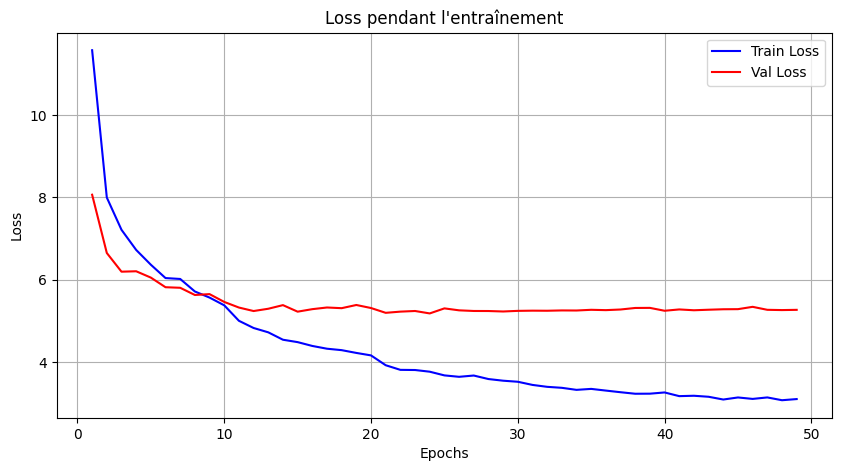

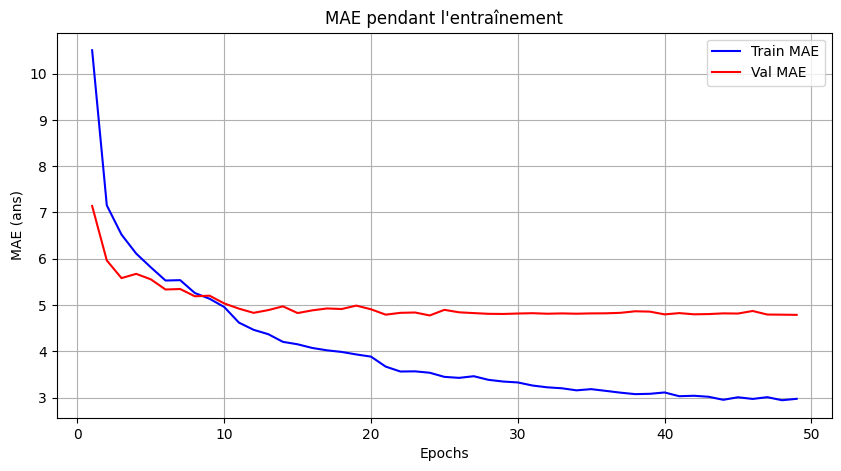

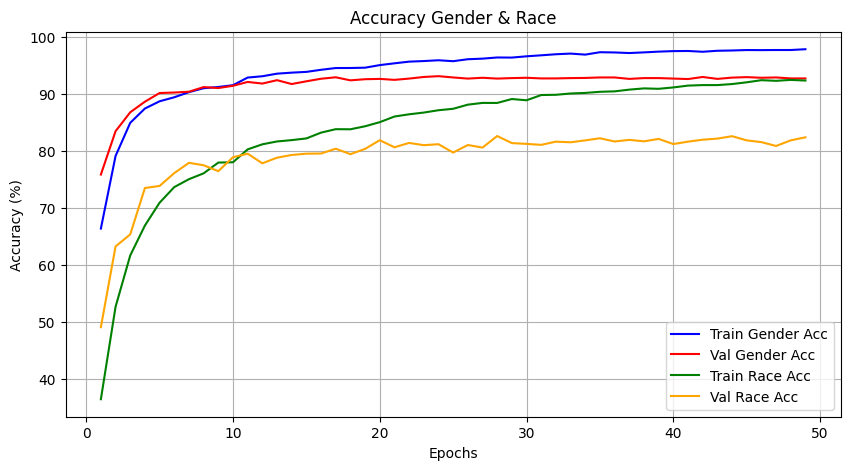

In [23]:
import matplotlib.pyplot as plt

# ==========================
# Affichage des courbes
# ==========================

# Extraire les métriques depuis l'historique
train_loss = [h['loss'] for h in history['train']]
val_loss = [h['loss'] for h in history['val']]

train_mae = [h['mae'] for h in history['train']]
val_mae = [h['mae'] for h in history['val']]

train_gender_acc = [h['gender_acc']*100 for h in history['train']]
val_gender_acc = [h['gender_acc']*100 for h in history['val']]

train_race_acc = [h['race_acc']*100 for h in history['train']]
val_race_acc = [h['race_acc']*100 for h in history['val']]

epochs = range(1, len(history['train']) + 1)

# --------------------------
# Courbe Loss
# --------------------------
plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r-', label='Val Loss')
plt.title('Loss pendant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# Courbe MAE
# --------------------------
plt.figure(figsize=(10,5))
plt.plot(epochs, train_mae, 'b-', label='Train MAE')
plt.plot(epochs, val_mae, 'r-', label='Val MAE')
plt.title('MAE pendant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('MAE (ans)')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# Courbes Accuracy (optionnel)
# --------------------------
plt.figure(figsize=(10,5))
plt.plot(epochs, train_gender_acc, 'b-', label='Train Gender Acc')
plt.plot(epochs, val_gender_acc, 'r-', label='Val Gender Acc')
plt.plot(epochs, train_race_acc, 'g-', label='Train Race Acc')
plt.plot(epochs, val_race_acc, 'orange', label='Val Race Acc')
plt.title('Accuracy Gender & Race')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


📌 Prédiction pour l'image : /kaggle/input/utkface-dataset-face-aligned-and-labeled/utkface-aligned-labeled/images/100_0_0_20170112213500903.jpg.chip.jpg
Âge prédit : 82.2 ans
Genre prédit : Homme
Ethnie prédite : Asian


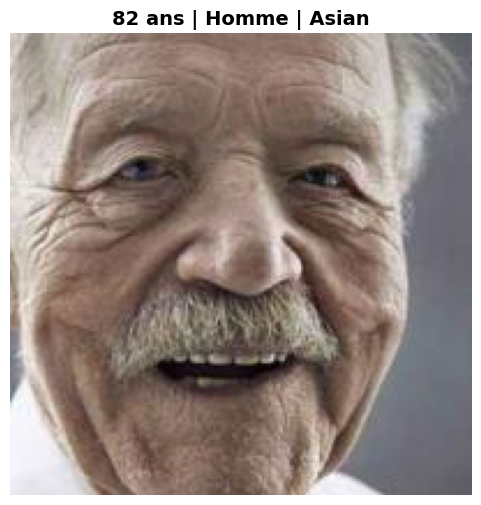

In [24]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Charger le modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskResNet50()  # ✅ instanciation
checkpoint = torch.load("best_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# Préparer l'image
image_path = "/kaggle/input/utkface-dataset-face-aligned-and-labeled/utkface-aligned-labeled/images/100_0_0_20170112213500903.jpg.chip.jpg"
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

img = Image.open(image_path).convert('RGB')
img_tensor = transform(img).unsqueeze(0).to(device)

# Prédiction
with torch.no_grad():
    age_out, gender_out, race_out = model(img_tensor)

# Décodage
pred_age = age_out.item()
pred_gender = "Femme" if torch.sigmoid(gender_out).item() > 0.5 else "Homme"
race_classes = ['White', 'Black', 'Asian', 'Indian', 'Others']  # adapter
pred_race = race_classes[torch.argmax(race_out,1).item()]

print(f"📌 Prédiction pour l'image : {image_path}")
print(f"Âge prédit : {pred_age:.1f} ans")
print(f"Genre prédit : {pred_gender}")
print(f"Ethnie prédite : {pred_race}")

# Afficher l'image avec prédictions
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.title(f"{pred_age:.0f} ans | {pred_gender} | {pred_race}", fontsize=14, fontweight='bold')
plt.show()


📌 Prédiction pour l'image : https://tse4.mm.bing.net/th/id/OIP.sYbvsbtTjUHtQ8JbhfphNAHaHZ?pid=Api&P=0&h=180
Âge prédit : 26.0 ans
Genre prédit : Femme
Ethnie prédite : Asian


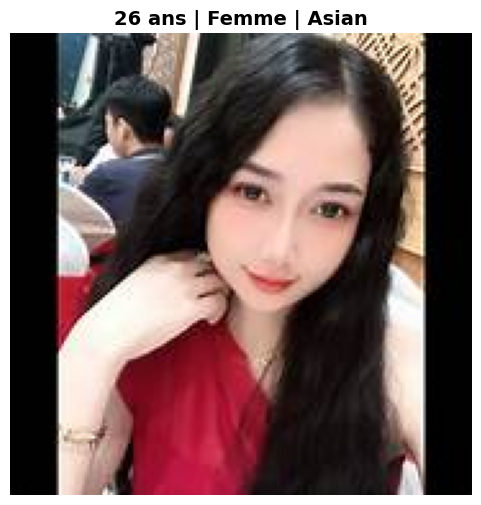

In [25]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO  # pour lire l'image depuis la mémoire

# Charger le modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskResNet50()  # instanciation
checkpoint = torch.load("best_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# Préparer l'image depuis une URL
image_url = "https://tse4.mm.bing.net/th/id/OIP.sYbvsbtTjUHtQ8JbhfphNAHaHZ?pid=Api&P=0&h=180"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content)).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

img_tensor = transform(img).unsqueeze(0).to(device)

# Prédiction
with torch.no_grad():
    age_out, gender_out, race_out = model(img_tensor)

# Décodage
pred_age = age_out.item()
pred_gender = "Femme" if torch.sigmoid(gender_out).item() > 0.5 else "Homme"
race_classes = ['White', 'Black', 'Asian', 'Indian', 'Others']  # adapter
pred_race = race_classes[torch.argmax(race_out,1).item()]

print(f"📌 Prédiction pour l'image : {image_url}")
print(f"Âge prédit : {pred_age:.1f} ans")
print(f"Genre prédit : {pred_gender}")
print(f"Ethnie prédite : {pred_race}")

# Afficher l'image avec prédictions
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.title(f"{pred_age:.0f} ans | {pred_gender} | {pred_race}", fontsize=14, fontweight='bold')
plt.show()


📌 Prédiction pour l'image : https://tse1.mm.bing.net/th/id/OIP.Brcn6oJ5yfR_pCLrwmpADAHaHa?pid=Api&P=0&h=180
Âge prédit : 1.2 ans
Genre prédit : Homme
Ethnie prédite : White


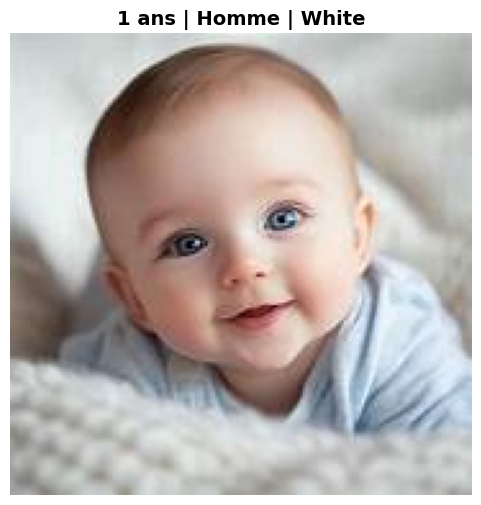

In [26]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO  # pour lire l'image depuis la mémoire

# Charger le modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskResNet50()  # instanciation
checkpoint = torch.load("best_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# Préparer l'image depuis une URL
image_url = "https://tse1.mm.bing.net/th/id/OIP.Brcn6oJ5yfR_pCLrwmpADAHaHa?pid=Api&P=0&h=180"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content)).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

img_tensor = transform(img).unsqueeze(0).to(device)

# Prédiction
with torch.no_grad():
    age_out, gender_out, race_out = model(img_tensor)

# Décodage
pred_age = age_out.item()
pred_gender = "Femme" if torch.sigmoid(gender_out).item() > 0.5 else "Homme"
race_classes = ['White', 'Black', 'Asian', 'Indian', 'Others']  # adapter
pred_race = race_classes[torch.argmax(race_out,1).item()]

print(f"📌 Prédiction pour l'image : {image_url}")
print(f"Âge prédit : {pred_age:.1f} ans")
print(f"Genre prédit : {pred_gender}")
print(f"Ethnie prédite : {pred_race}")

# Afficher l'image avec prédictions
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.title(f"{pred_age:.0f} ans | {pred_gender} | {pred_race}", fontsize=14, fontweight='bold')
plt.show()


📌 Prédiction pour l'image : https://tse3.mm.bing.net/th/id/OIP.BrtBPl3Ep0f2Dd6Dk7n-XQHaJQ?pid=Api&P=0&h=180
Âge prédit : 29.8 ans
Genre prédit : Femme
Ethnie prédite : White


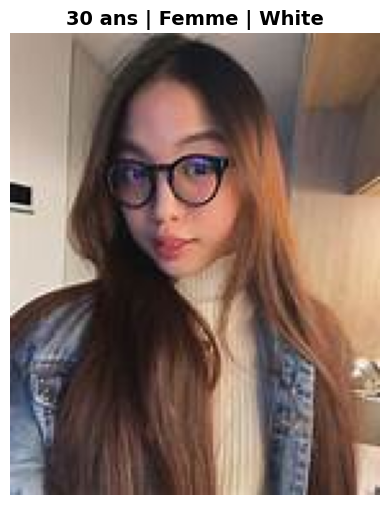

In [27]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO  # pour lire l'image depuis la mémoire

# Charger le modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskResNet50()  # instanciation
checkpoint = torch.load("best_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# Préparer l'image depuis une URL
image_url = "https://tse3.mm.bing.net/th/id/OIP.BrtBPl3Ep0f2Dd6Dk7n-XQHaJQ?pid=Api&P=0&h=180"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content)).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

img_tensor = transform(img).unsqueeze(0).to(device)

# Prédiction
with torch.no_grad():
    age_out, gender_out, race_out = model(img_tensor)

# Décodage
pred_age = age_out.item()
pred_gender = "Femme" if torch.sigmoid(gender_out).item() > 0.5 else "Homme"
race_classes = ['White', 'Black', 'Asian', 'Indian', 'Others']  # adapter
pred_race = race_classes[torch.argmax(race_out,1).item()]

print(f"📌 Prédiction pour l'image : {image_url}")
print(f"Âge prédit : {pred_age:.1f} ans")
print(f"Genre prédit : {pred_gender}")
print(f"Ethnie prédite : {pred_race}")

# Afficher l'image avec prédictions
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.title(f"{pred_age:.0f} ans | {pred_gender} | {pred_race}", fontsize=14, fontweight='bold')
plt.show()
